## Streamflow Routing (SFR) Package problem 1 with MVR applied among advanced packages

This is the stream-aquifer interaction example problem (test 1) from the
Streamflow Routing Package documentation (Prudic, 1989) with a couple of
modifications for demonstrating MVR connections among the advanced packages.
All reaches have been converted to rectangular reaches.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-sfr-p01b"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Model setup

Define functions to build models, write input files, and run the simulation.

In [2]:
# Model units
length_units = "feet"
time_units = "seconds"

# Model parameters
nper = 24  # Number of periods
nlay = 2  # Number of layers
nrow = 15  # Number of rows
ncol = 10  # Number of columns
delr = 5000.0  # Column width ($ft$)
delc = 5000.0  # Row width ($ft$)
strt = "varies"  # Starting head ($ft$)
k11_stream = 0.002  # Hydraulic conductivity near the stream ($ft/s$)
k11_basin = "varies"  # Hydraulic conductivity in the basin ($ft/s$)
lake_leakance = 2e-9  # Lakebed leakance ($1/s$)
ss = 0.1e-5  # Specific storage ($1/s$)
sy_stream = 0.2  # Specific yield near the stream (unitless)
sy_basin = 0.1  # Specific yield in the basin (unitless)
evap_rate = 9.5e-8  # Evapotranspiration rate ($ft/s$)
ext_depth = 15.0  # Evapotranspiration extinction depth ($ft$)

# Time discretization
tdis_ds = (
    (2628000.0, 1, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
    (2628000.0, 15, 1.0),
)

# Define dimensions
extents = (0.0, delr * ncol, 0.0, delc * nrow)
shape2d = (nrow, ncol)
shape3d = (nlay, nrow, ncol)

# Load the idomain, lake locations, top, bottom, and evapotranspiration surface arrays
fname = "strt1.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:273db6e876e7cfb4985b0b09c232f7cc",
)
strt1 = np.loadtxt(fpath, dtype=float)
strt2 = strt1
strt = [strt1, strt2]
fname = "idomain.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:3fb0b80939ff6ccc9dc47d010e002a3c",
)
idomain1 = np.loadtxt(fpath, dtype=int)
idomain = [idomain1, idomain1]
lake_map = np.ones(shape3d, dtype=int) * -1
fname = "lakes.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:c344195438bda85738cab2ce34a16733",
)
lake_map[0, :, :] = np.loadtxt(fpath, dtype=int) - 1
lake_map = np.ma.masked_where(lake_map < 0, lake_map)
fname = "top1.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:ba3f1422f45388b19dc1ef6b3076fa96",
)
top = np.loadtxt(fpath, dtype=float)
fname = "bot1.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:4343c79bbf3ad039638d2379d335d06e",
)
bot1 = np.loadtxt(fpath, dtype=float)
bot2 = np.ones_like(bot1) * 300.0
botm = [bot1, bot2]

# Create hydraulic conductivity and specific yield
fname = "k11_lay1.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:287160064d1a9bc0bae94b018bf187d7",
)
k11_lay1 = np.loadtxt(fpath, dtype=float) * 2.5
k11_lay2 = np.ones_like(k11_lay1) * 0.35e-2
k11 = [k11_lay1, k11_lay2]
k33 = 0.5e-5
fname = "sy1.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:80be4a9ba817465cf5c05934f94dd675",
)
sy1 = np.loadtxt(fpath, dtype=float)
sy2 = np.ones_like(sy1) * 0.20
sy = [sy1, sy2]

# General head boundary conditions
ghb_spd = [
    [0, 12, 0, 988.0, 0.038],
    [0, 13, 8, 1045.0, 0.038],
]

# Well boundary conditions
wel_spd = {
    0: [
        [0, 5, 3, 0],
        [0, 5, 4, 0],
        [0, 6, 3, 0],
        [0, 6, 4, 0],
        [0, 7, 3, 0],
        [0, 7, 4, 0],
        [0, 8, 3, 0],
        [0, 8, 4, 0],
        [0, 9, 3, 0],
        [0, 9, 4, 0],
    ],
    2: [
        [0, 5, 3, -0.85],
        [0, 5, 4, -0.85],
        [0, 6, 3, -0.85],
        [0, 6, 4, -0.85],
        [0, 7, 3, -0.85],
        [0, 7, 4, -0.85],
        [0, 8, 3, -0.85],
        [0, 8, 4, -0.85],
        [0, 9, 3, -0.85],
        [0, 9, 4, -0.85],
    ],
    4: [
        [0, 5, 3, -1.7],
        [0, 5, 4, -1.7],
        [0, 6, 3, -1.7],
        [0, 6, 4, -1.7],
        [0, 7, 3, -1.7],
        [0, 7, 4, -1.7],
        [0, 8, 3, -1.7],
        [0, 8, 4, -1.7],
        [0, 9, 3, -1.7],
        [0, 9, 4, -1.7],
    ],
    5: [
        [0, 5, 3, 0.00],
        [0, 5, 4, 0.00],
        [0, 6, 3, 0.00],
        [0, 6, 4, 0.00],
        [0, 7, 3, 0.00],
        [0, 7, 4, 0.00],
        [0, 8, 3, 0.00],
        [0, 8, 4, 0.00],
        [0, 9, 3, 0.00],
        [0, 9, 4, 0.00],
    ],
    6: [
        [0, 5, 3, -0.85],
        [0, 5, 4, -0.85],
        [0, 6, 3, -0.85],
        [0, 6, 4, -0.85],
        [0, 7, 3, -0.85],
        [0, 7, 4, -0.85],
        [0, 8, 3, -0.85],
        [0, 8, 4, -0.85],
        [0, 9, 3, -0.85],
        [0, 9, 4, -0.85],
    ],
    7: [
        [0, 5, 3, 0.00],
        [0, 5, 4, 0.00],
        [0, 6, 3, 0.00],
        [0, 6, 4, 0.00],
        [0, 7, 3, 0.00],
        [0, 7, 4, 0.00],
        [0, 8, 3, 0.00],
        [0, 8, 4, 0.00],
        [0, 9, 3, 0.00],
        [0, 9, 4, 0.00],
    ],
    8: [
        [0, 5, 3, -0.85],
        [0, 5, 4, -0.85],
        [0, 6, 3, -0.85],
        [0, 6, 4, -0.85],
        [0, 7, 3, -0.85],
        [0, 7, 4, -0.85],
        [0, 8, 3, -0.85],
        [0, 8, 4, -0.85],
        [0, 9, 3, -0.85],
        [0, 9, 4, -0.85],
    ],
    9: [
        [0, 5, 3, 0.00],
        [0, 5, 4, 0.00],
        [0, 6, 3, 0.00],
        [0, 6, 4, 0.00],
        [0, 7, 3, 0.00],
        [0, 7, 4, 0.00],
        [0, 8, 3, 0.00],
        [0, 8, 4, 0.00],
        [0, 9, 3, 0.00],
        [0, 9, 4, 0.00],
    ],
    10: [
        [0, 5, 3, -2.55],
        [0, 5, 4, -2.55],
        [0, 6, 3, -2.55],
        [0, 6, 4, -2.55],
        [0, 7, 3, -2.55],
        [0, 7, 4, -2.55],
        [0, 8, 3, -2.55],
        [0, 8, 4, -2.55],
        [0, 9, 3, -2.55],
        [0, 9, 4, -2.55],
    ],
    11: [
        [0, 5, 3, 0.00],
        [0, 5, 4, 0.00],
        [0, 6, 3, 0.00],
        [0, 6, 4, 0.00],
        [0, 7, 3, 0.00],
        [0, 7, 4, 0.00],
        [0, 8, 3, 0.00],
        [0, 8, 4, 0.00],
        [0, 9, 3, 0.00],
        [0, 9, 4, 0.00],
    ],
}

# SFR Package
sfr_pakdata = [
    (
        0,
        (0, 0, 0),
        4500.0,
        12.0,
        0.0008677,
        1093.048,
        3,
        3.0e-06,
        0.03,
        1,
        1.0,
        0,
        "allreaches",
    ),
    (
        1,
        (0, 1, 1),
        7000.0,
        12.0,
        0.0008677,
        1088.059,
        3,
        3.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        2,
        (0, 2, 2),
        6000.0,
        12.0,
        0.0008677,
        1082.419,
        3,
        3.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        3,
        (0, 2, 3),
        5550.0,
        12.0,
        0.0008677,
        1077.408,
        3,
        3.0e-06,
        0.03,
        3,
        1.0,
        1,
        "allreaches",
    ),
    (
        4,
        (0, 3, 4),
        6500.0,
        12.0,
        0.0009434,
        1071.934,
        3,
        3.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        5,
        (0, 4, 5),
        5000.0,
        12.0,
        0.0009434,
        1066.509,
        3,
        3.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        6,
        (0, 5, 5),
        5000.0,
        12.0,
        0.0009434,
        1061.792,
        3,
        3.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        7,
        (0, 6, 5),
        5000.0,
        12.0,
        0.0009434,
        1057.075,
        3,
        3.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        8,
        (0, 7, 5),
        5000.0,
        12.0,
        0.0009434,
        1052.359,
        3,
        3.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        9,
        (0, 2, 4),
        5000.0,
        9.636364,
        0.0005455,
        1073.636,
        2,
        3.0e-07,
        0.03,
        2,
        0.0,
        0,
        "allreaches",
    ),
    (
        10,
        (0, 2, 5),
        5000.0,
        8.909091,
        0.0005455,
        1070.909,
        2,
        3.0e-07,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        11,
        (0, 2, 6),
        4500.0,
        8.218182,
        0.0005455,
        1068.318,
        2,
        3.0e-07,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        12,
        (0, 3, 7),
        6000.0,
        7.454545,
        0.0005455,
        1065.455,
        2,
        3.0e-07,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        13,
        (0, 4, 7),
        5000.0,
        6.654546,
        0.0005455,
        1062.455,
        2,
        3.0e-07,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        14,
        (0, 5, 7),
        2000.0,
        6.145454,
        0.0005455,
        1060.545,
        2,
        3.0e-07,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        15,
        (0, 4, 9),
        2500.0,
        10.0,
        0.0018182,
        1077.727,
        3,
        3.0e-06,
        0.03,
        1,
        1.0,
        0,
        "allreaches",
    ),
    (
        16,
        (0, 4, 8),
        5000.0,
        10.0,
        0.0018182,
        1070.909,
        3,
        3.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        17,
        (0, 5, 7),
        3500.0,
        10.0,
        0.0018182,
        1063.182,
        3,
        3.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        18,
        (0, 5, 7),
        4000.0,
        10.0,
        0.0006667,
        1058.667,
        3,
        3.0e-06,
        0.03,
        3,
        1.0,
        0,
        "allreaches",
    ),
    (
        19,
        (0, 6, 6),
        5000.0,
        10.0,
        0.0006667,
        1055.667,
        3,
        3.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        20,
        (0, 7, 6),
        3500.0,
        10.0,
        0.0006667,
        1052.833,
        3,
        3.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        21,
        (0, 7, 5),
        2500.0,
        10.0,
        0.0006667,
        1050.833,
        3,
        3.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        22,
        (0, 8, 5),
        5000.0,
        12.0,
        0.0018000,
        1045.500,
        3,
        3.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        23,
        (0, 11, 6),
        5000.0,
        12.0,
        0.0014286,
        1036.429,
        3,
        3.0e-07,
        0.03,
        1,
        1.0,
        0,
        "allreaches",
    ),
    (
        24,
        (0, 12, 6),
        5500.0,
        12.0,
        0.0014286,
        1028.929,
        3,
        3.0e-07,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        25,
        (0, 13, 8),
        5000.0,
        60.0,
        0.0006667,
        1033.333,
        3,
        6.0e-06,
        0.03,
        1,
        1.0,
        0,
        "allreaches",
    ),
    (
        26,
        (0, 12, 7),
        5000.0,
        60.0,
        0.0006667,
        1030.000,
        3,
        6.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        27,
        (0, 12, 6),
        5000.0,
        60.0,
        0.0006667,
        1026.667,
        3,
        6.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        28,
        (0, 12, 5),
        5000.0,
        60.0,
        0.0048000,
        1013.000,
        3,
        6.0e-06,
        0.03,
        2,
        1.0,
        0,
        "allreaches",
    ),
    (
        29,
        (0, 12, 1),
        5000.0,
        60.0,
        0.0012500,
        996.875,
        3,
        6.0e-06,
        0.03,
        1,
        1.0,
        0,
        "allreaches",
    ),
    (
        30,
        (0, 12, 0),
        3000.0,
        60.0,
        0.0012500,
        991.875,
        3,
        6.0e-06,
        0.03,
        1,
        1.0,
        0,
        "allreaches",
    ),
]

sfr_conn = [
    [0, -1],
    [1, 0, -2],
    [2, 1, -3],
    [3, 2, -4, -9],
    [4, 3, -5],
    [5, 4, -6],
    [6, 5, -7],
    [7, 6, -8],
    [8, 7, -22],
    [9, 3, -10],
    [10, 9, -11],
    [11, 10, -12],
    [12, 11, -13],
    [13, 12, -14],
    [14, 13, -18],
    [15, -16],
    [16, 15, -17],
    [17, 16, -18],
    [18, 14, 17, -19],
    [19, 18, -20],
    [20, 19, -21],
    [21, 20, -22],
    [22, 8, 21],
    [23, -24],
    [24, 23, -28],
    [25, -26],
    [26, 25, -27],
    [27, 26, -28],
    [28, 24, 27],
    [29, -30],
    [30, 29],
]

sfr_div = [[3, 0, 9, "UPTO"]]

sfr_spd = [
    [0, "inflow", 25.0],
    [3, "diversion", 0, 10.0],
    [15, "inflow", 10.0],
    [25, "inflow", 150.0],
]

# UZF Package
uzf_pakdata = [
    (0, (0, 0, 0), 1, 100, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (1, (0, 0, 1), 1, 101, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (2, (0, 1, 0), 1, 102, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (3, (0, 1, 1), 1, 103, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (4, (0, 1, 2), 1, 104, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (5, (0, 1, 5), 1, 105, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (6, (0, 1, 6), 1, 106, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (7, (0, 1, 7), 1, 107, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (8, (0, 2, 1), 1, 108, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (9, (0, 2, 2), 1, 109, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (10, (0, 2, 3), 1, 110, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (11, (0, 2, 4), 1, 111, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (12, (0, 2, 5), 1, 112, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (13, (0, 2, 6), 1, 113, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (14, (0, 2, 7), 1, 114, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (15, (0, 3, 0), 1, 115, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (16, (0, 3, 1), 1, 116, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (17, (0, 3, 2), 1, 117, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (18, (0, 3, 3), 1, 118, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (19, (0, 3, 4), 1, 119, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (20, (0, 3, 5), 1, 120, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (21, (0, 3, 6), 1, 121, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (22, (0, 3, 7), 1, 122, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (23, (0, 3, 8), 1, 123, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (24, (0, 4, 0), 1, 124, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (25, (0, 4, 1), 1, 125, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (26, (0, 4, 2), 1, 126, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (27, (0, 4, 3), 1, 127, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (28, (0, 4, 4), 1, 128, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (29, (0, 4, 5), 1, 129, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (30, (0, 4, 6), 1, 130, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (31, (0, 4, 7), 1, 131, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (32, (0, 4, 8), 1, 132, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (33, (0, 4, 9), 1, 133, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (34, (0, 5, 0), 1, 134, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (35, (0, 5, 1), 1, 135, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (36, (0, 5, 2), 1, 136, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (37, (0, 5, 3), 1, 137, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (38, (0, 5, 4), 1, 138, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (39, (0, 5, 5), 1, 139, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (40, (0, 5, 6), 1, 140, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (41, (0, 5, 7), 1, 141, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (42, (0, 5, 8), 1, 142, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (43, (0, 5, 9), 1, 143, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (44, (0, 6, 0), 1, 144, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (45, (0, 6, 1), 1, 145, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (46, (0, 6, 2), 1, 146, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (47, (0, 6, 3), 1, 147, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (48, (0, 6, 4), 1, 148, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (49, (0, 6, 5), 1, 149, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (50, (0, 6, 6), 1, 150, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (51, (0, 6, 7), 1, 151, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (52, (0, 6, 8), 1, 152, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (53, (0, 7, 1), 1, 153, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (54, (0, 7, 2), 1, 154, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (55, (0, 7, 3), 1, 155, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (56, (0, 7, 4), 1, 156, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (57, (0, 7, 5), 1, 157, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (58, (0, 7, 6), 1, 158, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (59, (0, 7, 7), 1, 159, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (60, (0, 7, 8), 1, 160, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (61, (0, 8, 1), 1, 161, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (62, (0, 8, 2), 1, 162, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (63, (0, 8, 3), 1, 163, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (64, (0, 8, 4), 1, 164, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (65, (0, 8, 5), 1, 165, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (66, (0, 8, 6), 1, 166, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (67, (0, 8, 7), 1, 167, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (68, (0, 8, 8), 1, 168, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (69, (0, 9, 1), 1, 169, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (70, (0, 9, 2), 1, 170, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (71, (0, 9, 3), 1, 171, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (72, (0, 9, 4), 1, 172, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (73, (0, 9, 5), 1, 173, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (74, (0, 9, 8), 1, 174, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (75, (0, 9, 9), 1, 175, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (76, (0, 10, 1), 1, 176, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (77, (0, 10, 5), 1, 177, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (78, (0, 10, 8), 1, 178, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (79, (0, 11, 0), 1, 179, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (80, (0, 11, 1), 1, 180, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (81, (0, 11, 5), 1, 181, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (82, (0, 11, 6), 1, 182, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (83, (0, 11, 7), 1, 183, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (84, (0, 11, 8), 1, 184, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (85, (0, 12, 0), 1, 185, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (86, (0, 12, 1), 1, 186, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (87, (0, 12, 5), 1, 187, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (88, (0, 12, 6), 1, 188, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (89, (0, 12, 7), 1, 189, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (90, (0, 12, 8), 1, 190, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (91, (0, 13, 1), 1, 191, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (92, (0, 13, 5), 1, 192, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (93, (0, 13, 6), 1, 193, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (94, (0, 13, 7), 1, 194, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (95, (0, 13, 8), 1, 195, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (96, (0, 14, 2), 1, 196, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (97, (0, 14, 3), 1, 197, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (98, (0, 14, 4), 1, 198, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (99, (0, 14, 5), 1, 199, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (100, (1, 0, 0), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (101, (1, 0, 1), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (102, (1, 1, 0), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (103, (1, 1, 1), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (104, (1, 1, 2), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (105, (1, 1, 5), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (106, (1, 1, 6), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (107, (1, 1, 7), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (108, (1, 2, 1), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (109, (1, 2, 2), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (110, (1, 2, 3), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (111, (1, 2, 4), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (112, (1, 2, 5), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (113, (1, 2, 6), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (114, (1, 2, 7), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (115, (1, 3, 0), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (116, (1, 3, 1), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (117, (1, 3, 2), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (118, (1, 3, 3), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (119, (1, 3, 4), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (120, (1, 3, 5), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (121, (1, 3, 6), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (122, (1, 3, 7), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (123, (1, 3, 8), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (124, (1, 4, 0), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (125, (1, 4, 1), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (126, (1, 4, 2), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (127, (1, 4, 3), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (128, (1, 4, 4), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (129, (1, 4, 5), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (130, (1, 4, 6), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (131, (1, 4, 7), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (132, (1, 4, 8), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (133, (1, 4, 9), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (134, (1, 5, 0), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (135, (1, 5, 1), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (136, (1, 5, 2), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (137, (1, 5, 3), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (138, (1, 5, 4), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (139, (1, 5, 5), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (140, (1, 5, 6), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (141, (1, 5, 7), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (142, (1, 5, 8), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (143, (1, 5, 9), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (144, (1, 6, 0), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (145, (1, 6, 1), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (146, (1, 6, 2), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (147, (1, 6, 3), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (148, (1, 6, 4), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (149, (1, 6, 5), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (150, (1, 6, 6), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (151, (1, 6, 7), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (152, (1, 6, 8), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (153, (1, 7, 1), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (154, (1, 7, 2), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (155, (1, 7, 3), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (156, (1, 7, 4), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (157, (1, 7, 5), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (158, (1, 7, 6), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (159, (1, 7, 7), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (160, (1, 7, 8), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (161, (1, 8, 1), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (162, (1, 8, 2), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (163, (1, 8, 3), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (164, (1, 8, 4), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (165, (1, 8, 5), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (166, (1, 8, 6), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (167, (1, 8, 7), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (168, (1, 8, 8), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (169, (1, 9, 1), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (170, (1, 9, 2), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (171, (1, 9, 3), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (172, (1, 9, 4), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "ag"),
    (173, (1, 9, 5), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (174, (1, 9, 8), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (175, (1, 9, 9), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (176, (1, 10, 1), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (177, (1, 10, 5), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (178, (1, 10, 8), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (179, (1, 11, 0), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (180, (1, 11, 1), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (181, (1, 11, 5), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (182, (1, 11, 6), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (183, (1, 11, 7), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (184, (1, 11, 8), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (185, (1, 12, 0), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (186, (1, 12, 1), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (187, (1, 12, 5), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (188, (1, 12, 6), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (189, (1, 12, 7), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (190, (1, 12, 8), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (191, (1, 13, 1), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (192, (1, 13, 5), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (193, (1, 13, 6), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (194, (1, 13, 7), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (195, (1, 13, 8), 0, -1, 0.1, 0.000001, 0.1, 0.3, 0.11, 3.5, "uzfcells"),
    (196, (1, 14, 2), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (197, (1, 14, 3), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (198, (1, 14, 4), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
    (199, (1, 14, 5), 0, -1, 0.1, 0.000001, 0.2, 0.3, 0.21, 3.5, "uzfcells"),
]

finf = [
    [
        3.34e-10,
        6.68e-10,
        6.68e-10,
        3.34e-10,
        6.68e-10,
        2.68e-09,
        2.68e-09,
        1.67e-09,
        1.67e-09,
        3.34e-10,
        3.34e-10,
        2.68e-09,
        2.68e-09,
        1.67e-09,
        1.67e-09,
        2.68e-09,
        1.67e-09,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        6.68e-10,
        2.68e-09,
        1.67e-09,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        2.68e-09,
        1.67e-09,
        1.67e-09,
        6.68e-10,
        6.68e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        1.67e-09,
        2.68e-09,
        1.67e-09,
        1.67e-09,
        6.68e-10,
        6.68e-10,
        3.34e-10,
        3.34e-10,
        6.68e-10,
        6.68e-10,
        1.67e-09,
        1.67e-09,
        6.68e-10,
        6.68e-10,
        3.34e-10,
        3.34e-10,
        6.68e-10,
        1.67e-09,
        1.67e-09,
        1.67e-09,
        6.68e-10,
        6.68e-10,
        3.34e-10,
        3.34e-10,
        6.68e-10,
        1.67e-09,
        1.67e-09,
        1.67e-09,
        6.68e-10,
        6.68e-10,
        3.34e-10,
        1.67e-09,
        2.68e-09,
        3.34e-10,
        3.34e-10,
        1.67e-09,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        6.68e-10,
        3.34e-10,
        3.34e-10,
        6.68e-10,
        6.68e-10,
        3.34e-10,
        3.34e-10,
        6.68e-10,
        1.67e-09,
        1.67e-09,
        6.68e-10,
        3.34e-10,
        2.68e-09,
        2.68e-09,
        2.68e-09,
        2.68e-09,
    ],
    [
        4.00e-08,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        8.00e-08,
        3.20e-07,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        3.20e-07,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        3.20e-07,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        3.20e-07,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        2.00e-07,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        2.00e-07,
        3.20e-07,
        4.00e-08,
        4.00e-08,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        4.00e-08,
        3.20e-07,
        3.20e-07,
        3.20e-07,
        3.20e-07,
    ],
    [
        1.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-08,
        2.00e-08,
        8.00e-08,
        8.00e-08,
        5.00e-08,
        5.00e-08,
        1.00e-08,
        1.00e-08,
        8.00e-08,
        8.00e-08,
        5.00e-08,
        5.00e-08,
        8.00e-08,
        5.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        2.00e-08,
        8.00e-08,
        5.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        8.00e-08,
        5.00e-08,
        5.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        5.00e-08,
        8.00e-08,
        5.00e-08,
        5.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-08,
        1.00e-08,
        2.00e-08,
        2.00e-08,
        5.00e-08,
        5.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-08,
        1.00e-08,
        2.00e-08,
        5.00e-08,
        5.00e-08,
        5.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-08,
        1.00e-08,
        2.00e-08,
        5.00e-08,
        5.00e-08,
        5.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-08,
        5.00e-08,
        8.00e-08,
        1.00e-08,
        1.00e-08,
        5.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        2.00e-08,
        1.00e-08,
        1.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-08,
        1.00e-08,
        2.00e-08,
        5.00e-08,
        5.00e-08,
        2.00e-08,
        1.00e-08,
        8.00e-08,
        8.00e-08,
        8.00e-08,
        8.00e-08,
    ],
    [
        2.00e-08,
        4.00e-08,
        4.00e-08,
        2.00e-08,
        4.00e-08,
        1.60e-07,
        1.60e-07,
        1.00e-07,
        1.00e-07,
        2.00e-08,
        2.00e-08,
        1.60e-07,
        1.60e-07,
        1.00e-07,
        1.00e-07,
        1.60e-07,
        1.00e-07,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        4.00e-08,
        1.60e-07,
        1.00e-07,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        1.60e-07,
        1.00e-07,
        1.00e-07,
        4.00e-08,
        4.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-07,
        1.60e-07,
        1.00e-07,
        1.00e-07,
        4.00e-08,
        4.00e-08,
        2.00e-08,
        2.00e-08,
        4.00e-08,
        4.00e-08,
        1.00e-07,
        1.00e-07,
        4.00e-08,
        4.00e-08,
        2.00e-08,
        2.00e-08,
        4.00e-08,
        1.00e-07,
        1.00e-07,
        1.00e-07,
        4.00e-08,
        4.00e-08,
        2.00e-08,
        2.00e-08,
        4.00e-08,
        1.00e-07,
        1.00e-07,
        1.00e-07,
        4.00e-08,
        4.00e-08,
        2.00e-08,
        1.00e-07,
        1.60e-07,
        2.00e-08,
        2.00e-08,
        1.00e-07,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        4.00e-08,
        2.00e-08,
        2.00e-08,
        4.00e-08,
        4.00e-08,
        2.00e-08,
        2.00e-08,
        4.00e-08,
        1.00e-07,
        1.00e-07,
        4.00e-08,
        2.00e-08,
        1.60e-07,
        1.60e-07,
        1.60e-07,
        1.60e-07,
    ],
    [
        2.50e-08,
        5.00e-08,
        5.00e-08,
        2.50e-08,
        5.00e-08,
        2.00e-07,
        2.00e-07,
        1.25e-07,
        1.25e-07,
        2.50e-08,
        2.50e-08,
        2.00e-07,
        2.00e-07,
        1.25e-07,
        1.25e-07,
        2.00e-07,
        1.25e-07,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        5.00e-08,
        2.00e-07,
        1.25e-07,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.00e-07,
        1.25e-07,
        1.25e-07,
        5.00e-08,
        5.00e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        1.25e-07,
        2.00e-07,
        1.25e-07,
        1.25e-07,
        5.00e-08,
        5.00e-08,
        2.50e-08,
        2.50e-08,
        5.00e-08,
        5.00e-08,
        1.25e-07,
        1.25e-07,
        5.00e-08,
        5.00e-08,
        2.50e-08,
        2.50e-08,
        5.00e-08,
        1.25e-07,
        1.25e-07,
        1.25e-07,
        5.00e-08,
        5.00e-08,
        2.50e-08,
        2.50e-08,
        5.00e-08,
        1.25e-07,
        1.25e-07,
        1.25e-07,
        5.00e-08,
        5.00e-08,
        2.50e-08,
        1.25e-07,
        2.00e-07,
        2.50e-08,
        2.50e-08,
        1.25e-07,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        5.00e-08,
        2.50e-08,
        2.50e-08,
        5.00e-08,
        5.00e-08,
        2.50e-08,
        2.50e-08,
        5.00e-08,
        1.25e-07,
        1.25e-07,
        5.00e-08,
        2.50e-08,
        2.00e-07,
        2.00e-07,
        2.00e-07,
        2.00e-07,
    ],
    [
        4.00e-08,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        8.00e-08,
        3.20e-07,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        3.20e-07,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        3.20e-07,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        3.20e-07,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        2.00e-07,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        2.00e-07,
        3.20e-07,
        4.00e-08,
        4.00e-08,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        4.00e-08,
        3.20e-07,
        3.20e-07,
        3.20e-07,
        3.20e-07,
    ],
    [
        3.00e-09,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        6.00e-09,
        2.40e-08,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        2.40e-08,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        2.40e-08,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        2.40e-08,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        1.50e-08,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        1.50e-08,
        2.40e-08,
        3.00e-09,
        3.00e-09,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        3.00e-09,
        2.40e-08,
        2.40e-08,
        2.40e-08,
        2.40e-08,
    ],
    [
        5.00e-09,
        1.00e-08,
        1.00e-08,
        5.00e-09,
        1.00e-08,
        4.00e-08,
        4.00e-08,
        2.50e-08,
        2.50e-08,
        5.00e-09,
        5.00e-09,
        4.00e-08,
        4.00e-08,
        2.50e-08,
        2.50e-08,
        4.00e-08,
        2.50e-08,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        1.00e-08,
        4.00e-08,
        2.50e-08,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        4.00e-08,
        2.50e-08,
        2.50e-08,
        1.00e-08,
        1.00e-08,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        2.50e-08,
        4.00e-08,
        2.50e-08,
        2.50e-08,
        1.00e-08,
        1.00e-08,
        5.00e-09,
        5.00e-09,
        1.00e-08,
        1.00e-08,
        2.50e-08,
        2.50e-08,
        1.00e-08,
        1.00e-08,
        5.00e-09,
        5.00e-09,
        1.00e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        1.00e-08,
        1.00e-08,
        5.00e-09,
        5.00e-09,
        1.00e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        1.00e-08,
        1.00e-08,
        5.00e-09,
        2.50e-08,
        4.00e-08,
        5.00e-09,
        5.00e-09,
        2.50e-08,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        1.00e-08,
        5.00e-09,
        5.00e-09,
        1.00e-08,
        1.00e-08,
        5.00e-09,
        5.00e-09,
        1.00e-08,
        2.50e-08,
        2.50e-08,
        1.00e-08,
        5.00e-09,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
    ],
    [
        3.00e-09,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        6.00e-09,
        2.40e-08,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        2.40e-08,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        2.40e-08,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        2.40e-08,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        1.50e-08,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        1.50e-08,
        2.40e-08,
        3.00e-09,
        3.00e-09,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        3.00e-09,
        2.40e-08,
        2.40e-08,
        2.40e-08,
        2.40e-08,
    ],
    [
        2.00e-09,
        4.00e-09,
        4.00e-09,
        2.00e-09,
        4.00e-09,
        1.60e-08,
        1.60e-08,
        1.00e-08,
        1.00e-08,
        2.00e-09,
        2.00e-09,
        1.60e-08,
        1.60e-08,
        1.00e-08,
        1.00e-08,
        1.60e-08,
        1.00e-08,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        4.00e-09,
        1.60e-08,
        1.00e-08,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        1.60e-08,
        1.00e-08,
        1.00e-08,
        4.00e-09,
        4.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-08,
        1.60e-08,
        1.00e-08,
        1.00e-08,
        4.00e-09,
        4.00e-09,
        2.00e-09,
        2.00e-09,
        4.00e-09,
        4.00e-09,
        1.00e-08,
        1.00e-08,
        4.00e-09,
        4.00e-09,
        2.00e-09,
        2.00e-09,
        4.00e-09,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        4.00e-09,
        4.00e-09,
        2.00e-09,
        2.00e-09,
        4.00e-09,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        4.00e-09,
        4.00e-09,
        2.00e-09,
        1.00e-08,
        1.60e-08,
        2.00e-09,
        2.00e-09,
        1.00e-08,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        4.00e-09,
        2.00e-09,
        2.00e-09,
        4.00e-09,
        4.00e-09,
        2.00e-09,
        2.00e-09,
        4.00e-09,
        1.00e-08,
        1.00e-08,
        4.00e-09,
        2.00e-09,
        1.60e-08,
        1.60e-08,
        1.60e-08,
        1.60e-08,
    ],
    [
        1.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        2.00e-09,
        8.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        8.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        8.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        8.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        5.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        5.00e-09,
        8.00e-09,
        1.00e-09,
        1.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        1.00e-09,
        8.00e-09,
        8.00e-09,
        8.00e-09,
        8.00e-09,
    ],
    [
        1.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        2.00e-09,
        8.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        8.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        8.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        8.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        5.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        5.00e-09,
        8.00e-09,
        1.00e-09,
        1.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        1.00e-09,
        8.00e-09,
        8.00e-09,
        8.00e-09,
        8.00e-09,
    ],
    [
        3.34e-10,
        6.68e-10,
        6.68e-10,
        3.34e-10,
        6.68e-10,
        2.68e-09,
        2.68e-09,
        1.67e-09,
        1.67e-09,
        3.34e-10,
        3.34e-10,
        2.68e-09,
        2.68e-09,
        1.67e-09,
        1.67e-09,
        2.68e-09,
        1.67e-09,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        6.68e-10,
        2.68e-09,
        1.67e-09,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        2.68e-09,
        1.67e-09,
        1.67e-09,
        6.68e-10,
        6.68e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        1.67e-09,
        2.68e-09,
        1.67e-09,
        1.67e-09,
        6.68e-10,
        6.68e-10,
        3.34e-10,
        3.34e-10,
        6.68e-10,
        6.68e-10,
        1.67e-09,
        1.67e-09,
        6.68e-10,
        6.68e-10,
        3.34e-10,
        3.34e-10,
        6.68e-10,
        1.67e-09,
        1.67e-09,
        1.67e-09,
        6.68e-10,
        6.68e-10,
        3.34e-10,
        3.34e-10,
        6.68e-10,
        1.67e-09,
        1.67e-09,
        1.67e-09,
        6.68e-10,
        6.68e-10,
        3.34e-10,
        1.67e-09,
        2.68e-09,
        3.34e-10,
        3.34e-10,
        1.67e-09,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        3.34e-10,
        6.68e-10,
        3.34e-10,
        3.34e-10,
        6.68e-10,
        6.68e-10,
        3.34e-10,
        3.34e-10,
        6.68e-10,
        1.67e-09,
        1.67e-09,
        6.68e-10,
        3.34e-10,
        2.68e-09,
        2.68e-09,
        2.68e-09,
        2.68e-09,
    ],
    [
        4.00e-08,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        8.00e-08,
        3.20e-07,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        3.20e-07,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        3.20e-07,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        3.20e-07,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        2.00e-07,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        2.00e-07,
        3.20e-07,
        4.00e-08,
        4.00e-08,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        4.00e-08,
        3.20e-07,
        3.20e-07,
        3.20e-07,
        3.20e-07,
    ],
    [
        1.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-08,
        2.00e-08,
        8.00e-08,
        8.00e-08,
        5.00e-08,
        5.00e-08,
        1.00e-08,
        1.00e-08,
        8.00e-08,
        8.00e-08,
        5.00e-08,
        5.00e-08,
        8.00e-08,
        5.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        2.00e-08,
        8.00e-08,
        5.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        8.00e-08,
        5.00e-08,
        5.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        5.00e-08,
        8.00e-08,
        5.00e-08,
        5.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-08,
        1.00e-08,
        2.00e-08,
        2.00e-08,
        5.00e-08,
        5.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-08,
        1.00e-08,
        2.00e-08,
        5.00e-08,
        5.00e-08,
        5.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-08,
        1.00e-08,
        2.00e-08,
        5.00e-08,
        5.00e-08,
        5.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-08,
        5.00e-08,
        8.00e-08,
        1.00e-08,
        1.00e-08,
        5.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        2.00e-08,
        1.00e-08,
        1.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-08,
        1.00e-08,
        2.00e-08,
        5.00e-08,
        5.00e-08,
        2.00e-08,
        1.00e-08,
        8.00e-08,
        8.00e-08,
        8.00e-08,
        8.00e-08,
    ],
    [
        2.00e-08,
        4.00e-08,
        4.00e-08,
        2.00e-08,
        4.00e-08,
        1.60e-07,
        1.60e-07,
        1.00e-07,
        1.00e-07,
        2.00e-08,
        2.00e-08,
        1.60e-07,
        1.60e-07,
        1.00e-07,
        1.00e-07,
        1.60e-07,
        1.00e-07,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        4.00e-08,
        1.60e-07,
        1.00e-07,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        1.60e-07,
        1.00e-07,
        1.00e-07,
        4.00e-08,
        4.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        1.00e-07,
        1.60e-07,
        1.00e-07,
        1.00e-07,
        4.00e-08,
        4.00e-08,
        2.00e-08,
        2.00e-08,
        4.00e-08,
        4.00e-08,
        1.00e-07,
        1.00e-07,
        4.00e-08,
        4.00e-08,
        2.00e-08,
        2.00e-08,
        4.00e-08,
        1.00e-07,
        1.00e-07,
        1.00e-07,
        4.00e-08,
        4.00e-08,
        2.00e-08,
        2.00e-08,
        4.00e-08,
        1.00e-07,
        1.00e-07,
        1.00e-07,
        4.00e-08,
        4.00e-08,
        2.00e-08,
        1.00e-07,
        1.60e-07,
        2.00e-08,
        2.00e-08,
        1.00e-07,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        2.00e-08,
        4.00e-08,
        2.00e-08,
        2.00e-08,
        4.00e-08,
        4.00e-08,
        2.00e-08,
        2.00e-08,
        4.00e-08,
        1.00e-07,
        1.00e-07,
        4.00e-08,
        2.00e-08,
        1.60e-07,
        1.60e-07,
        1.60e-07,
        1.60e-07,
    ],
    [
        2.50e-08,
        5.00e-08,
        5.00e-08,
        2.50e-08,
        5.00e-08,
        2.00e-07,
        2.00e-07,
        1.25e-07,
        1.25e-07,
        2.50e-08,
        2.50e-08,
        2.00e-07,
        2.00e-07,
        1.25e-07,
        1.25e-07,
        2.00e-07,
        1.25e-07,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        5.00e-08,
        2.00e-07,
        1.25e-07,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.00e-07,
        1.25e-07,
        1.25e-07,
        5.00e-08,
        5.00e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        1.25e-07,
        2.00e-07,
        1.25e-07,
        1.25e-07,
        5.00e-08,
        5.00e-08,
        2.50e-08,
        2.50e-08,
        5.00e-08,
        5.00e-08,
        1.25e-07,
        1.25e-07,
        5.00e-08,
        5.00e-08,
        2.50e-08,
        2.50e-08,
        5.00e-08,
        1.25e-07,
        1.25e-07,
        1.25e-07,
        5.00e-08,
        5.00e-08,
        2.50e-08,
        2.50e-08,
        5.00e-08,
        1.25e-07,
        1.25e-07,
        1.25e-07,
        5.00e-08,
        5.00e-08,
        2.50e-08,
        1.25e-07,
        2.00e-07,
        2.50e-08,
        2.50e-08,
        1.25e-07,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        5.00e-08,
        2.50e-08,
        2.50e-08,
        5.00e-08,
        5.00e-08,
        2.50e-08,
        2.50e-08,
        5.00e-08,
        1.25e-07,
        1.25e-07,
        5.00e-08,
        2.50e-08,
        2.00e-07,
        2.00e-07,
        2.00e-07,
        2.00e-07,
    ],
    [
        4.00e-08,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        8.00e-08,
        3.20e-07,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        3.20e-07,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        3.20e-07,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        3.20e-07,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        2.00e-07,
        3.20e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        2.00e-07,
        3.20e-07,
        4.00e-08,
        4.00e-08,
        2.00e-07,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        8.00e-08,
        4.00e-08,
        4.00e-08,
        8.00e-08,
        2.00e-07,
        2.00e-07,
        8.00e-08,
        4.00e-08,
        3.20e-07,
        3.20e-07,
        3.20e-07,
        3.20e-07,
    ],
    [
        3.00e-09,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        6.00e-09,
        2.40e-08,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        2.40e-08,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        2.40e-08,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        2.40e-08,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        1.50e-08,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        1.50e-08,
        2.40e-08,
        3.00e-09,
        3.00e-09,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        3.00e-09,
        2.40e-08,
        2.40e-08,
        2.40e-08,
        2.40e-08,
    ],
    [
        5.00e-09,
        1.00e-08,
        1.00e-08,
        5.00e-09,
        1.00e-08,
        4.00e-08,
        4.00e-08,
        2.50e-08,
        2.50e-08,
        5.00e-09,
        5.00e-09,
        4.00e-08,
        4.00e-08,
        2.50e-08,
        2.50e-08,
        4.00e-08,
        2.50e-08,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        1.00e-08,
        4.00e-08,
        2.50e-08,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        4.00e-08,
        2.50e-08,
        2.50e-08,
        1.00e-08,
        1.00e-08,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        2.50e-08,
        4.00e-08,
        2.50e-08,
        2.50e-08,
        1.00e-08,
        1.00e-08,
        5.00e-09,
        5.00e-09,
        1.00e-08,
        1.00e-08,
        2.50e-08,
        2.50e-08,
        1.00e-08,
        1.00e-08,
        5.00e-09,
        5.00e-09,
        1.00e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        1.00e-08,
        1.00e-08,
        5.00e-09,
        5.00e-09,
        1.00e-08,
        2.50e-08,
        2.50e-08,
        2.50e-08,
        1.00e-08,
        1.00e-08,
        5.00e-09,
        2.50e-08,
        4.00e-08,
        5.00e-09,
        5.00e-09,
        2.50e-08,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        1.00e-08,
        5.00e-09,
        5.00e-09,
        1.00e-08,
        1.00e-08,
        5.00e-09,
        5.00e-09,
        1.00e-08,
        2.50e-08,
        2.50e-08,
        1.00e-08,
        5.00e-09,
        4.00e-08,
        4.00e-08,
        4.00e-08,
        4.00e-08,
    ],
    [
        3.00e-09,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        6.00e-09,
        2.40e-08,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        2.40e-08,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        2.40e-08,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        2.40e-08,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        1.50e-08,
        2.40e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        1.50e-08,
        2.40e-08,
        3.00e-09,
        3.00e-09,
        1.50e-08,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        6.00e-09,
        3.00e-09,
        3.00e-09,
        6.00e-09,
        1.50e-08,
        1.50e-08,
        6.00e-09,
        3.00e-09,
        2.40e-08,
        2.40e-08,
        2.40e-08,
        2.40e-08,
    ],
    [
        2.00e-09,
        4.00e-09,
        4.00e-09,
        2.00e-09,
        4.00e-09,
        1.60e-08,
        1.60e-08,
        1.00e-08,
        1.00e-08,
        2.00e-09,
        2.00e-09,
        1.60e-08,
        1.60e-08,
        1.00e-08,
        1.00e-08,
        1.60e-08,
        1.00e-08,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        4.00e-09,
        1.60e-08,
        1.00e-08,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        1.60e-08,
        1.00e-08,
        1.00e-08,
        4.00e-09,
        4.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-08,
        1.60e-08,
        1.00e-08,
        1.00e-08,
        4.00e-09,
        4.00e-09,
        2.00e-09,
        2.00e-09,
        4.00e-09,
        4.00e-09,
        1.00e-08,
        1.00e-08,
        4.00e-09,
        4.00e-09,
        2.00e-09,
        2.00e-09,
        4.00e-09,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        4.00e-09,
        4.00e-09,
        2.00e-09,
        2.00e-09,
        4.00e-09,
        1.00e-08,
        1.00e-08,
        1.00e-08,
        4.00e-09,
        4.00e-09,
        2.00e-09,
        1.00e-08,
        1.60e-08,
        2.00e-09,
        2.00e-09,
        1.00e-08,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        2.00e-09,
        4.00e-09,
        2.00e-09,
        2.00e-09,
        4.00e-09,
        4.00e-09,
        2.00e-09,
        2.00e-09,
        4.00e-09,
        1.00e-08,
        1.00e-08,
        4.00e-09,
        2.00e-09,
        1.60e-08,
        1.60e-08,
        1.60e-08,
        1.60e-08,
    ],
    [
        1.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        2.00e-09,
        8.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        8.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        8.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        8.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        5.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        5.00e-09,
        8.00e-09,
        1.00e-09,
        1.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        1.00e-09,
        8.00e-09,
        8.00e-09,
        8.00e-09,
        8.00e-09,
    ],
    [
        1.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        2.00e-09,
        8.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        8.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        8.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        8.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        5.00e-09,
        8.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        5.00e-09,
        8.00e-09,
        1.00e-09,
        1.00e-09,
        5.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        2.00e-09,
        1.00e-09,
        1.00e-09,
        2.00e-09,
        5.00e-09,
        5.00e-09,
        2.00e-09,
        1.00e-09,
        8.00e-09,
        8.00e-09,
        8.00e-09,
        8.00e-09,
    ],
]

extwc = [
    0.100005,
    0.100005,
    0.200010,
    0.100005,
    0.100005,
    0.200010,
    0.200010,
    0.200010,
    0.200010,
    0.100005,
    0.100005,
    0.200010,
    0.200010,
    0.200010,
    0.200010,
    0.200010,
    0.200010,
    0.200010,
    0.100005,
    0.100005,
    0.100005,
    0.200010,
    0.200010,
    0.200010,
    0.200010,
    0.200010,
    0.200010,
    0.100005,
    0.100005,
    0.100005,
    0.100005,
    0.100005,
    0.100005,
    0.100005,
    0.200010,
    0.200010,
    0.200010,
    0.100005,
    0.100005,
    0.100005,
    0.100005,
    0.100005,
    0.200010,
    0.200010,
    0.200010,
    0.200010,
    0.200010,
    0.100005,
    0.100005,
    0.100005,
    0.100005,
    0.100005,
    0.200010,
    0.200010,
    0.200010,
    0.100005,
    0.100005,
    0.100005,
    0.100005,
    0.200010,
    0.200010,
    0.200010,
    0.200010,
    0.100005,
    0.100005,
    0.100005,
    0.100005,
    0.200010,
    0.200010,
    0.200010,
    0.200010,
    0.100005,
    0.100005,
    0.100005,
    0.200010,
    0.200010,
    0.200010,
    0.100005,
    0.200010,
    0.200010,
    0.200010,
    0.100005,
    0.100005,
    0.200010,
    0.200010,
    0.100005,
    0.100005,
    0.100005,
    0.100005,
    0.100005,
    0.100005,
    0.200010,
    0.200010,
    0.200010,
    0.200010,
    0.100005,
    0.200010,
    0.200010,
    0.200010,
    0.200010,
]

uzf_spd = {}
pET = 1.00e-08
extdp = 15.0
ha = 0.0
hroot = 0.0
rootact = 0.0
for tm in range(len(tdis_ds)):
    sp = []
    iuzno = 0
    for i in range(len(extwc)):
        sp.append((iuzno, finf[tm][i], pET, extdp, extwc[i], ha, hroot, rootact))
        iuzno += 1
    uzf_spd.update({int(tm): sp})

lak_stage = (
    1040.0,
    1010.0,
)

lak_outlets = [
    [0, 0, -1, "MANNING", 1040.0004, 12.0, 0.29999999e-01, 0.14285709e-02],
    [1, 1, -1, "MANNING", 1000.0000, 60.0, 0.29999999e-01, 0.12500000e-02],
]

lk_spd = {
    0: [
        [0, "rainfall", 0.500e-07],
        [0, "evaporation", 0.100e-07],
        [0, "runoff", 1.50],
        [0, "withdrawal", 0.00],
        [1, "rainfall", 0.120e-07],
        [1, "evaporation", 0.110e-07],
        [1, "runoff", 3.00],
        [1, "withdrawal", 0.12],
    ]
}

# MVR Package
mvr_pack = [["UZF-1"], ["SFR-1"], ["LAK-1"], ["WEL-1"]]
maxpackages = len(mvr_pack)
max_mvr = 200
mvr_spd = {
    0: [
        ("SFR-1", 22, "LAK-1", 0, "FACTOR", 1.0),
        ("LAK-1", 0, "SFR-1", 23, "FACTOR", 1.0),
        ("SFR-1", 28, "LAK-1", 1, "FACTOR", 1.0),
        ("LAK-1", 1, "SFR-1", 29, "FACTOR", 1.0),
        ("UZF-1", 0, "SFR-1", 0, "FACTOR", 1.0),
        ("UZF-1", 1, "SFR-1", 1, "FACTOR", 1.0),
        ("UZF-1", 2, "SFR-1", 1, "FACTOR", 1.0),
        ("UZF-1", 3, "SFR-1", 1, "FACTOR", 1.0),
        ("UZF-1", 4, "SFR-1", 2, "FACTOR", 1.0),
        ("UZF-1", 5, "SFR-1", 10, "FACTOR", 1.0),
        ("UZF-1", 6, "SFR-1", 11, "FACTOR", 1.0),
        ("UZF-1", 7, "SFR-1", 11, "FACTOR", 1.0),
        ("UZF-1", 8, "SFR-1", 1, "FACTOR", 1.0),
        ("UZF-1", 9, "SFR-1", 2, "FACTOR", 1.0),
        ("UZF-1", 10, "SFR-1", 3, "FACTOR", 1.0),
        ("UZF-1", 11, "SFR-1", 9, "FACTOR", 1.0),
        ("UZF-1", 12, "SFR-1", 10, "FACTOR", 1.0),
        ("UZF-1", 13, "SFR-1", 11, "FACTOR", 1.0),
        ("UZF-1", 14, "SFR-1", 12, "FACTOR", 1.0),
        ("UZF-1", 15, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 16, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 17, "SFR-1", 2, "FACTOR", 1.0),
        ("UZF-1", 18, "SFR-1", 3, "FACTOR", 1.0),
        ("UZF-1", 19, "SFR-1", 4, "FACTOR", 1.0),
        ("UZF-1", 20, "SFR-1", 5, "FACTOR", 1.0),
        ("UZF-1", 21, "SFR-1", 5, "FACTOR", 1.0),
        ("UZF-1", 22, "SFR-1", 12, "FACTOR", 1.0),
        ("UZF-1", 23, "SFR-1", 16, "FACTOR", 1.0),
        ("UZF-1", 24, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 25, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 26, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 27, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 28, "SFR-1", 4, "FACTOR", 1.0),
        ("UZF-1", 29, "SFR-1", 5, "FACTOR", 1.0),
        ("UZF-1", 30, "SFR-1", 5, "FACTOR", 1.0),
        ("UZF-1", 31, "SFR-1", 13, "FACTOR", 1.0),
        ("UZF-1", 32, "SFR-1", 16, "FACTOR", 1.0),
        ("UZF-1", 33, "SFR-1", 15, "FACTOR", 1.0),
        ("UZF-1", 34, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 35, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 36, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 37, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 38, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 39, "SFR-1", 6, "FACTOR", 1.0),
        ("UZF-1", 40, "SFR-1", 6, "FACTOR", 1.0),
        ("UZF-1", 41, "SFR-1", 18, "FACTOR", 1.0),
        ("UZF-1", 42, "SFR-1", 16, "FACTOR", 1.0),
        ("UZF-1", 43, "SFR-1", 15, "FACTOR", 1.0),
        ("UZF-1", 44, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 45, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 46, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 47, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 48, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 49, "SFR-1", 7, "FACTOR", 1.0),
        ("UZF-1", 50, "SFR-1", 19, "FACTOR", 1.0),
        ("UZF-1", 51, "SFR-1", 19, "FACTOR", 1.0),
        ("UZF-1", 52, "SFR-1", 19, "FACTOR", 1.0),
        ("UZF-1", 53, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 54, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 55, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 56, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 57, "SFR-1", 8, "FACTOR", 1.0),
        ("UZF-1", 58, "SFR-1", 20, "FACTOR", 1.0),
        ("UZF-1", 59, "SFR-1", 20, "FACTOR", 1.0),
        ("UZF-1", 60, "SFR-1", 20, "FACTOR", 1.0),
        ("UZF-1", 61, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 62, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 63, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 64, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 65, "SFR-1", 22, "FACTOR", 1.0),
        ("UZF-1", 66, "LAK-1", 0, "FACTOR", 1.0),
        ("UZF-1", 67, "LAK-1", 0, "FACTOR", 1.0),
        ("UZF-1", 68, "LAK-1", 0, "FACTOR", 1.0),
        ("UZF-1", 69, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 70, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 71, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 72, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 73, "LAK-1", 0, "FACTOR", 1.0),
        ("UZF-1", 74, "LAK-1", 0, "FACTOR", 1.0),
        ("UZF-1", 75, "LAK-1", 0, "FACTOR", 1.0),
        ("UZF-1", 76, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 77, "SFR-1", 8, "FACTOR", 1.0),
        ("UZF-1", 78, "LAK-1", 0, "FACTOR", 1.0),
        ("UZF-1", 79, "SFR-1", 30, "FACTOR", 1.0),
        ("UZF-1", 80, "SFR-1", 29, "FACTOR", 1.0),
        ("UZF-1", 81, "SFR-1", 8, "FACTOR", 1.0),
        ("UZF-1", 82, "SFR-1", 23, "FACTOR", 1.0),
        ("UZF-1", 83, "LAK-1", 0, "FACTOR", 1.0),
        ("UZF-1", 84, "LAK-1", 0, "FACTOR", 1.0),
        ("UZF-1", 85, "SFR-1", 30, "FACTOR", 1.0),
        ("UZF-1", 86, "SFR-1", 29, "FACTOR", 1.0),
        ("UZF-1", 87, "SFR-1", 28, "FACTOR", 1.0),
        ("UZF-1", 88, "SFR-1", 27, "FACTOR", 1.0),
        ("UZF-1", 89, "SFR-1", 26, "FACTOR", 1.0),
        ("UZF-1", 90, "SFR-1", 25, "FACTOR", 1.0),
        ("UZF-1", 91, "SFR-1", 29, "FACTOR", 1.0),
        ("UZF-1", 92, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 93, "SFR-1", 27, "FACTOR", 1.0),
        ("UZF-1", 94, "SFR-1", 26, "FACTOR", 1.0),
        ("UZF-1", 95, "SFR-1", 25, "FACTOR", 1.0),
        ("UZF-1", 96, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 97, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 98, "LAK-1", 1, "FACTOR", 1.0),
        ("UZF-1", 99, "LAK-1", 1, "FACTOR", 1.0),
        ("WEL-1", 0, "UZF-1", 37, "FACTOR", 1.0),
        ("WEL-1", 1, "UZF-1", 38, "FACTOR", 1.0),
        ("WEL-1", 2, "UZF-1", 47, "FACTOR", 1.0),
        ("WEL-1", 3, "UZF-1", 48, "FACTOR", 1.0),
        ("WEL-1", 4, "UZF-1", 55, "FACTOR", 1.0),
        ("WEL-1", 5, "UZF-1", 56, "FACTOR", 1.0),
        ("WEL-1", 6, "UZF-1", 63, "FACTOR", 1.0),
        ("WEL-1", 7, "UZF-1", 64, "FACTOR", 1.0),
        ("WEL-1", 8, "UZF-1", 71, "FACTOR", 1.0),
        ("WEL-1", 9, "UZF-1", 72, "FACTOR", 1.0),
    ]
}

# Solver parameters
nouter = 100
ninner = 50
hclose = 1e-6
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models():
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        complexity="complex",
        outer_dvclose=1.0e-4,
        outer_maximum=2000,
        under_relaxation="dbd",
        linear_acceleration="BICGSTAB",
        under_relaxation_theta=0.7,
        under_relaxation_kappa=0.08,
        under_relaxation_gamma=0.05,
        under_relaxation_momentum=0.0,
        backtracking_number=20,
        backtracking_tolerance=2.0,
        backtracking_reduction_factor=0.2,
        backtracking_residual_limit=5.0e-4,
        inner_dvclose=1.0e-5,
        rcloserecord="0.0001 relative_rclose",
        inner_maximum=100,
        relaxation_factor=0.0,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
    )
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=sim_name, newtonoptions="newton", save_flows=True
    )
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        idomain=idomain,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        alternative_cell_averaging="AMT-HMK",
        icelltype=1,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfsto(
        gwf,
        iconvert=1,
        sy=sy,
        ss=ss,
        steady_state={0: True},
        transient={1: True},
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfghb(gwf, stress_period_data=ghb_spd)
    flopy.mf6.ModflowGwfwel(
        gwf,
        print_input=True,
        print_flows=True,
        save_flows=True,
        mover=True,
        pname="WEL-1",
        stress_period_data=wel_spd,
    )
    sfr = flopy.mf6.ModflowGwfsfr(
        gwf,
        print_flows=True,
        print_stage=True,
        save_flows=True,
        boundnames=True,
        budget_filerecord=sim_name + ".sfr.bud",
        mover=True,
        pname="SFR-1",
        maximum_depth_change=0.1e-05,
        length_conversion=3.28081,
        nreaches=len(sfr_pakdata),
        packagedata=sfr_pakdata,
        connectiondata=sfr_conn,
        diversions=sfr_div,
        perioddata=sfr_spd,
        filename=f"{sim_name}.sfr",
    )
    sfr_obs_file = f"{sim_name}.sfr.obs"
    sfr_obs_dict = {
        "sfr.reach01.csv": [
            ("extin", "ext-inflow", (0,)),
            ("inflow", "inflow", (0,)),
            ("frommvr", "from-mvr", (0,)),
            ("gwf", "sfr", (0,)),
            ("outflow", "outflow", (0,)),
            ("extout", "ext-outflow", (0,)),
            ("tomvr", "to-mvr", (0,)),
        ],
        "sfr.reach24.csv": [
            ("extin", "ext-inflow", (23,)),
            ("inflow", "inflow", (23,)),
            ("frommvr", "from-mvr", (23,)),
            ("gwf", "sfr", (23,)),
            ("outflow", "outflow", (23,)),
            ("extout", "ext-outflow", (23,)),
            ("tomvr", "to-mvr", (23,)),
        ],
        "sfr.reach29.csv": [
            ("extin", "ext-inflow", (28,)),
            ("inflow", "inflow", (28,)),
            ("frommvr", "from-mvr", (28,)),
            ("gwf", "sfr", (28,)),
            ("outflow", "outflow", (28,)),
            ("extout", "ext-outflow", (28,)),
            ("tomvr", "to-mvr", (28,)),
        ],
        "sfr.reach31.csv": [
            ("extin", "ext-inflow", (30,)),
            ("inflow", "inflow", (30,)),
            ("frommvr", "from-mvr", (30,)),
            ("gwf", "sfr", (30,)),
            ("outflow", "outflow", (30,)),
            ("extout", "ext-outflow", (30,)),
            ("tomvr", "to-mvr", (30,)),
        ],
        "sfr.allreaches.csv": [
            ("extin", "ext-inflow", "allreaches"),
            ("inflow", "inflow", "allreaches"),
            ("frommvr", "from-mvr", "allreaches"),
            ("gwf", "sfr", "allreaches"),
            ("outflow", "outflow", "allreaches"),
            ("extout", "ext-outflow", "allreaches"),
            ("tomvr", "to-mvr", "allreaches"),
        ],
        "sfr.stage.csv": [
            ("s01", "stage", (0,)),
            ("s24", "stage", (23,)),
            ("s29", "stage", (28,)),
            ("s31", "stage", (30,)),
        ],
    }
    sfr.obs.initialize(
        filename=sfr_obs_file,
        digits=10,
        print_input=True,
        continuous=sfr_obs_dict,
    )

    (
        idomain_wlakes,
        lakepakdata_dict,
        lakeconnectiondata,
    ) = flopy.mf6.utils.get_lak_connections(
        gwf.modelgrid,
        lake_map,
        idomain=gwf.dis.idomain.array,
        bedleak=lake_leakance,
    )
    lak_pakdata = []
    for key in lakepakdata_dict.keys():
        lak_pakdata.append([key, lak_stage[key], lakepakdata_dict[key]])
    lak = flopy.mf6.ModflowGwflak(
        gwf,
        print_stage=True,
        print_flows=True,
        save_flows=True,
        budget_filerecord=sim_name + ".lak.bud",
        length_conversion=3.28081,
        mover=True,
        pname="LAK-1",
        boundnames=False,
        nlakes=len(lak_pakdata),
        noutlets=len(lak_outlets),
        outlets=lak_outlets,
        packagedata=lak_pakdata,
        connectiondata=lakeconnectiondata,
        perioddata=lk_spd,
        filename=f"{sim_name}.lak",
    )
    lak_obs_file = f"{sim_name}.lak.obs"
    lak_obs_dict = {
        "obs_lak.csv": [
            ("LAK1_STAGE", "STAGE", 1),
            ("LAK2_STAGE", "STAGE", 2),
            ("LAK1_TO-MVR", "TO-MVR", 1),
            ("LAK1_FROM-MVR", "FROM-MVR", 1),
            ("LAK2_TO-MVR", "TO-MVR", 2),
            ("LAK2_FROM-MVR", "FROM-MVR", 2),
        ]
    }
    lak.obs.initialize(filename=lak_obs_file, digits=10, continuous=lak_obs_dict)
    uzf = flopy.mf6.ModflowGwfuzf(
        gwf,
        nuzfcells=len(uzf_pakdata),
        boundnames=True,
        ntrailwaves=10,
        nwavesets=50,
        print_flows=False,
        save_flows=True,
        simulate_et=True,
        linear_gwet=True,
        simulate_gwseep=True,
        mover=True,
        packagedata=uzf_pakdata,
        perioddata=uzf_spd,
        budget_filerecord=f"{sim_name}.uzf.bud",
        pname="UZF-1",
        filename=f"{sim_name}.uzf",
    )
    uzf_obs_file = f"{sim_name}.uzf.obs"
    uzf_obs_dict = {
        "obs_uzf.csv": [
            ("ninfil", "net-infiltration", "ag"),
            ("rejinf", "rej-inf", "ag"),
            ("rejinfmvr", "rej-inf-to-mvr", "ag"),
            ("infil", "infiltration", "ag"),
            ("frommvr", "from-mvr", "ag"),
            ("gwrch", "uzf-gwrch", "ag"),
            ("gwet", "uzf-gwet", "ag"),
            ("uzet", "uzet", "ag"),
        ],
        "obs_uzf_column.csv": [
            ("id26_infil", "infiltration", 26),
            ("id126_infil", "infiltration", 126),
            ("id26_dpth=20", "water-content", 26, 20.0),
            (
                "id126_dpth=51",
                "water-content",
                126,
                1.0,
            ),  # DEPTH IS BELOW CELTOP
            ("id26_rch", "uzf-gwrch", 26),
            ("id126_rch", "uzf-gwrch", 126),
            ("id26_gwet", "uzf-gwet", 26),
            ("id126_gwet", "uzf-gwet", 126),
            ("id26_uzet", "uzet", 26),
            ("id126_uzet", "uzet", 126),
            ("id26_gwd2mvr", "uzf-gwd-to-mvr", 26),
            ("id126_gwd2mvr", "uzf-gwd-to-mvr", 126),
            ("id26_rejinf", "rej-inf-to-mvr", 26),
            ("id126_rejinf", "rej-inf-to-mvr", 126),
        ],
    }
    uzf.obs.initialize(filename=uzf_obs_file, print_input=True, continuous=uzf_obs_dict)
    flopy.mf6.ModflowGwfmvr(
        gwf,
        maxmvr=max_mvr,
        print_flows=True,
        maxpackages=maxpackages,
        packages=mvr_pack,
        perioddata=mvr_spd,
        pname="MVR-1",
        budget_filerecord=sim_name + ".mvr.bud",
        filename=f"{sim_name}.mvr",
    )

    # rest idomain with lake adjustments
    gwf.dis.idomain = idomain_wlakes

    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6.3, 5.6)
masked_values = (0, 1e30, -1e30)


def plot_grid(gwf, silent=True):
    with styles.USGSMap():
        fig = plt.figure(figsize=figure_size, constrained_layout=False)
        gs = mpl.gridspec.GridSpec(ncols=10, nrows=7, figure=fig, wspace=5)
        plt.axis("off")

        axes = []
        axes.append(fig.add_subplot(gs[:6, :5]))
        axes.append(fig.add_subplot(gs[:6, 5:], sharey=axes[0]))

        for ax in axes:
            ax.set_xlim(extents[:2])
            ax.set_ylim(extents[2:])
            ax.set_aspect("equal")

        # legend axis
        axes.append(fig.add_subplot(gs[6:, :]))

        # set limits for legend area
        ax = axes[-1]
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        # get rid of ticks and spines for legend area
        ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)

        ax = axes[0]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        top_coll = mm.plot_array(
            top, vmin=1000, vmax=1120, masked_values=masked_values, alpha=0.5
        )
        mm.plot_bc("SFR", color="green")
        cv = mm.contour_array(
            top,
            levels=np.arange(1000, 1100, 20),
            linewidths=0.5,
            linestyles="-",
            colors="black",
            masked_values=masked_values,
        )
        plt.clabel(cv, fmt="%1.0f")
        mm.plot_inactive(color_noflow="0.5")
        mm.plot_grid(lw=0.5, color="black")
        cbar = plt.colorbar(
            top_coll,
            shrink=0.8,
            orientation="horizontal",
            ax=ax,
            format="%.0f",
        )
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Land surface elevation, $ft$")
        ax.set_xlabel("x-coordinate, in feet")
        ax.set_ylabel("y-coordinate, in feet")
        styles.heading(ax, heading="Land surface elevation", idx=0)
        styles.remove_edge_ticks(ax)

        ax = axes[1]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        bot_coll = mm.plot_array(
            botm, vmin=950, vmax=1100, masked_values=masked_values, alpha=0.5
        )
        mm.plot_bc("GHB", color="purple")
        mm.plot_bc("WEL", color="red", kper=1)
        cv = mm.contour_array(
            botm,
            levels=np.arange(950, 1100, 20),
            linewidths=0.5,
            linestyles=":",
            colors="black",
            masked_values=masked_values,
        )
        plt.clabel(cv, fmt="%1.0f")
        mm.plot_inactive(color_noflow="0.5")
        mm.plot_grid(lw=0.5, color="black")
        cbar = plt.colorbar(
            bot_coll,
            shrink=0.8,
            orientation="horizontal",
            ax=ax,
            format="%.0f",
        )
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Bottom elevation, $ft$")
        ax.set_xlabel("x-coordinate, in feet")
        styles.heading(ax, heading="Bottom elevation", idx=1)
        styles.remove_edge_ticks(ax)

        # legend
        ax = axes[-1]
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="0.5",
            mec="black",
            markeredgewidth=0.5,
            label="Inactive cells",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="green",
            mec="black",
            markeredgewidth=0.5,
            label="Stream boundary",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="purple",
            mec="black",
            markeredgewidth=0.5,
            label="General head boundary",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="red",
            mec="black",
            markeredgewidth=0.5,
            label="Well boundary",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0.5,
            ls="-",
            color="black",
            label=r"Land surface elevation contour, $ft$",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0.5,
            ls=":",
            color="black",
            label=r"Bottom elevation contour, $ft$",
        )
        styles.graph_legend(ax, loc="center", ncol=3)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)


def plot_head_results(gwf, silent=True):
    # create MODFLOW 6 head object
    hobj = gwf.output.head()

    # create MODFLOW 6 cell-by-cell budget object
    cobj = gwf.output.budget()

    kstpkper = hobj.get_kstpkper()

    with styles.USGSMap():
        fig = plt.figure(figsize=figure_size, constrained_layout=False)
        gs = mpl.gridspec.GridSpec(ncols=10, nrows=7, figure=fig, wspace=5)
        plt.axis("off")

        axes = [fig.add_subplot(gs[:6, :5])]
        axes.append(fig.add_subplot(gs[:6, 5:], sharey=axes[0]))

        for ax in axes:
            ax.set_xlim(extents[:2])
            ax.set_ylim(extents[2:])
            ax.set_aspect("equal")

        # legend axis
        axes.append(fig.add_subplot(gs[6:, :]))

        # set limits for legend area
        ax = axes[-1]
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        # get rid of ticks and spines for legend area
        ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)

        # extract heads and specific discharge for first stress period
        head = hobj.get_data(kstpkper=kstpkper[0])
        qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
            cobj.get_data(text="DATA-SPDIS", kstpkper=kstpkper[0])[0],
            gwf,
        )

        ax = axes[0]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        head_coll = mm.plot_array(
            head, vmin=900, vmax=1120, masked_values=masked_values
        )
        cv = mm.contour_array(
            head,
            levels=np.arange(900, 1100, 10),
            linewidths=0.5,
            linestyles="-",
            colors="black",
            masked_values=masked_values,
        )
        plt.clabel(cv, fmt="%1.0f")
        mm.plot_vector(qx, qy, normalize=True, color="0.75")
        mm.plot_inactive(color_noflow="0.5")
        mm.plot_grid(lw=0.5, color="black")
        ax.set_xlabel("x-coordinate, in feet")
        ax.set_ylabel("y-coordinate, in feet")
        styles.heading(ax, heading="Steady-state", idx=0)
        styles.remove_edge_ticks(ax)

        # extract heads and specific discharge for second stress period
        head = hobj.get_data(kstpkper=kstpkper[1])
        qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
            cobj.get_data(text="DATA-SPDIS", kstpkper=kstpkper[1])[0],
            gwf,
        )

        ax = axes[1]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        head_coll = mm.plot_array(
            head, vmin=900, vmax=1120, masked_values=masked_values
        )
        cv = mm.contour_array(
            head,
            levels=np.arange(900, 1100, 10),
            linewidths=0.5,
            linestyles="-",
            colors="black",
            masked_values=masked_values,
        )
        plt.clabel(cv, fmt="%1.0f")
        mm.plot_vector(qx, qy, normalize=True, color="0.75")
        mm.plot_inactive(color_noflow="0.5")
        mm.plot_grid(lw=0.5, color="black")
        ax.set_xlabel("x-coordinate, in feet")
        styles.heading(ax, heading="Pumping", idx=1)
        styles.remove_edge_ticks(ax)

        # legend
        ax = axes[-1]
        cbar = plt.colorbar(
            head_coll,
            shrink=0.8,
            orientation="horizontal",
            ax=ax,
            format="%.0f",
        )
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Head, $ft$")
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="$\u2192$",
            ms=10,
            mfc="0.75",
            mec="0.75",
            label="Normalized specific discharge",
        )
        ax.plot(-10000, -10000, lw=0.5, color="black", label=r"Head contour, $ft$")
        styles.graph_legend(ax, loc="upper center", ncol=2)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-01.png"
            fig.savefig(fpth)


def plot_mvr_results(idx, gwf, silent=True):
    with styles.USGSPlot():
        # load the observations
        mvr = gwf.get_package("MVR-1")
        mvr_Q = mvr.output.budget()
        # This retrieves all of the MOVER fluxes:
        mvr_all = mvr_Q.get_data(text="      MOVER-FLOW")

        ckstpkper = mvr_Q.get_kstpkper()

        # The following will tell us the contents of MVR recarrays
        # mvr_Q.list_records()
        # Connections specified in MVR input include:
        # SFR -> LAK
        # LAK -> SFR
        # UZF -> SFR
        # UZF -> LAK
        # WEL -> UZF
        provider = b"WEL-1           "
        receiver1 = b"UZF-1           "
        gwirrig = []
        for i, kstpkper in enumerate(ckstpkper):
            # The following gets the actual indexes of where the conditions are
            # satisfied, which is what the recarray needs
            mvr_idxs = np.where(
                np.all(
                    (
                        np.array(mvr_Q.recordarray["kper"] == i),
                        np.array(mvr_Q.recordarray["paknam"] == provider),  # Provider
                        np.array(mvr_Q.recordarray["paknam2"] == receiver1),
                    ),
                    axis=0,
                )
            )  # Receiver

            tot_stp_gwirrig = 0
            if len(mvr_idxs[0]) > 0:
                mvr_welirrig = mvr_all[mvr_idxs[0][0]]
                # Loop through each row of the mvr_welirrig recarray for tallying
                # gw irrigation events on a cell-by-cell basis

                for k, itm in enumerate(mvr_welirrig):
                    # itm[1]: the receiver identifier. 2.6280e6: len of stress
                    # period - about 1 month
                    tot_stp_gwirrig += itm[2]

            gwirrig.append(abs(tot_stp_gwirrig) * 2.6280e6 / 43560)  # results in ac*ft

        # Get all groundwater discharge:
        provider = b"UZF-1           "
        receiver1 = b"SFR-1           "
        receiver2 = b"LAK-1           "
        tot_mvr_runoff = []
        for i, kstpkper in enumerate(ckstpkper):
            mvr_runoff = 0  # Initialize
            # The following gets the actual indexes of where the conditions are satisfied, which is what the recarray needs
            mvr_idxs = np.where(
                np.all(
                    (
                        np.array(mvr_Q.recordarray["kper"] == i),
                        np.array(mvr_Q.recordarray["paknam"] == provider),  # Provider
                        np.logical_or(
                            mvr_Q.recordarray["paknam2"] == receiver1,  # Receiver
                            mvr_Q.recordarray["paknam2"] == receiver2,
                        ),
                    ),
                    axis=0,
                )
            )
            # For each index (there will be two in this case because there are two receivers)
            for j in range(len(mvr_idxs[0])):
                mvr_rnf2sw = mvr_all[mvr_idxs[0][j]]
                # Loop through each row of the mvr_uzf2sw for tallying flow totals
                for k, itm in enumerate(mvr_rnf2sw):
                    mvr_runoff += itm[2]
            # Tally the result
            tot_mvr_runoff.append(abs(mvr_runoff) * 2.6280e6 / 43560)

        # Barplot of pumping and runoff
        # set width of bar
        barWidth = 0.25
        fig, ax = plt.subplots(figsize=figure_size)

        # set height of bar
        bardat = [gwirrig, tot_mvr_runoff]

        # Set position of bar on X axis
        br1 = np.arange(len(gwirrig)) + 1
        br2 = [x + barWidth for x in br1]

        # Make the plot
        plt.bar(
            br1,
            gwirrig,
            color="r",
            width=barWidth,
            edgecolor="grey",
            label="GW Irrig",
        )
        plt.bar(
            br2,
            tot_mvr_runoff,
            color="g",
            width=barWidth,
            edgecolor="grey",
            label="Runoff",
        )

        # Adding Xticks
        plt.xlabel("Month")
        plt.ylabel("Acre-feet")
        plt.legend()

        title = "Total monthly mvr flux"
        letter = chr(ord("@") + idx + 1)
        styles.heading(letter=letter, heading=title)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-mvr.png"
            fig.savefig(fpth)


def plot_uzfcolumn_results(idx, gwf, silent=True):
    with styles.USGSPlot():
        sim_ws = os.path.join(workspace, sim_name)
        fname = os.path.join(sim_ws, "obs_uzf_column.csv")
        uzf_dat = pd.read_csv(fname, header=0)
        uzf_dat["time_days"] = uzf_dat["time"] / 86400
        x = uzf_dat["time_days"]
        finf = uzf_dat["ID26_INFIL"] * 86400 / 43560
        wc = uzf_dat["ID26_DPTH=20"]
        rch = (uzf_dat["ID26_RCH"] + uzf_dat["ID126_RCH"]) * 86400 / 43560
        gwet = (uzf_dat["ID26_GWET"] + uzf_dat["ID126_GWET"]) * 86400 / 43560
        uzet = (uzf_dat["ID26_UZET"] + uzf_dat["ID126_UZET"]) * 86400 / 43560
        gwdisq = (uzf_dat["ID26_GWD2MVR"] + uzf_dat["ID126_GWD2MVR"]) * 86400 / 43560
        rejinf = (uzf_dat["ID26_REJINF"] + uzf_dat["ID126_REJINF"]) * 86400 / 43560

        fig = plt.figure(figsize=figure_size)
        ax1 = fig.add_subplot(1, 1, 1)

        ln1 = ax1.plot(x, finf, color="b", label="Infiltration")
        ln2 = ax1.plot(x, rch, color="g", label="Recharge")
        ax2 = ax1.twinx()
        ln3 = ax2.plot(x, wc, "r--", label="Water Content")

        ax1.set_xlabel("Days")
        ax1.set_ylabel("UZ Fluxes - Row 5, Column 2,  in ac*ft")
        ax1.set_xlim(0, 740)
        ax1.set_ylim(0, 16)
        ax2.set_ylim(0.14, 0.3)
        ax2.set_ylabel("Water Content")
        ax1.yaxis.grid("on")

        lns = ln1 + ln2 + ln3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper left")

        title = "Time series of UZ fluxes for row 5, column 2"
        letter = chr(ord("@") + idx + 2)
        styles.heading(letter=letter, heading=title)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-uz.png"
            fig.savefig(fpth)


def plot_results(idx, sim, silent=True):
    gwf = sim.get_model(sim_name)
    plot_grid(gwf, silent=silent)
    plot_head_results(gwf, silent=silent)
    plot_mvr_results(idx, gwf, silent=silent)
    plot_uzfcolumn_results(idx, gwf, silent=silent)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 11875.67 ms


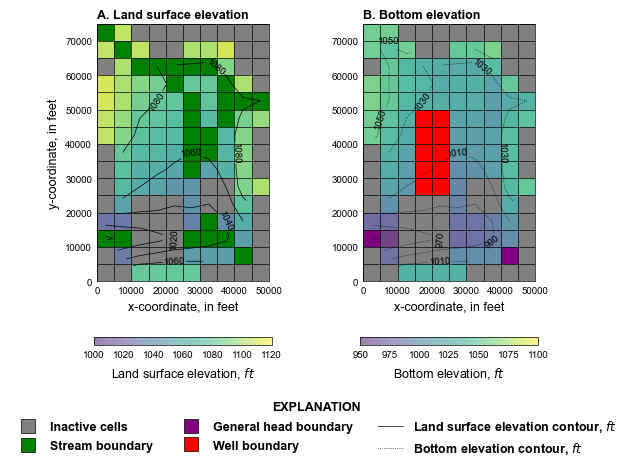

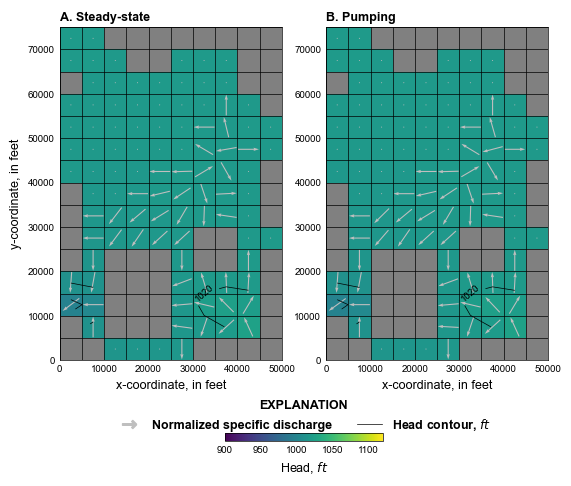

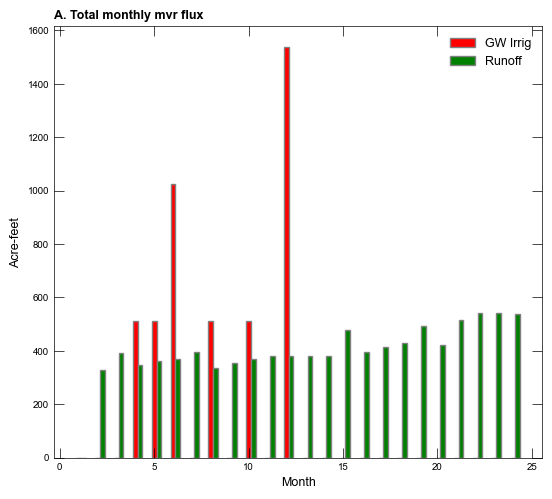

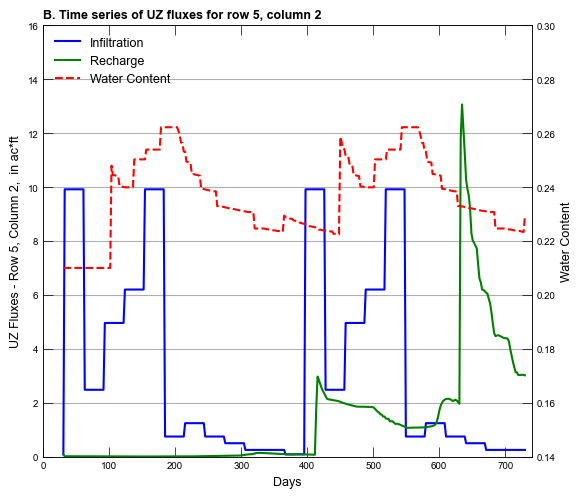

In [5]:
def simulation(idx, silent=True):
    sim = build_models()
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(idx, sim, silent=silent)


# Simulated heads in model the unconfined, middle, and lower aquifers (model layers
# 1, 3, and 5) are shown in the figure below. MODFLOW-2005 results for a quasi-3D
# model are also shown. The location of drain (green) and well (gray) boundary
# conditions, normalized specific discharge, and head contours (25 ft contour
# intervals) are also shown.
simulation(0)